In [1]:
import os
import hopsworks
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
with open('data/hopsworks-api-key.txt', 'r') as file:
    os.environ["HOPSWORKS_API_KEY"] = file.read().rstrip()
    
project = hopsworks.login()
fs = project.get_feature_store()

2024-12-29 19:39:34,242 INFO: Initializing external client
2024-12-29 19:39:34,243 INFO: Base URL: https://c.app.hopsworks.ai:443
2024-12-29 19:39:35,893 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1159324


In [3]:
grailed_items_fg = fs.get_feature_group(
    name='grailed_items',
    version=2,
)

In [4]:
grailed_items_fg.features

[Feature('id', 'bigint', None, True, False, None, None, 1394342),
 Feature('sold_at', 'timestamp', None, False, False, None, None, 1394342),
 Feature('category_path', 'string', None, False, False, None, None, 1394342),
 Feature('description', 'string', None, False, False, None, None, 1394342),
 Feature('size', 'string', None, False, False, None, None, 1394342),
 Feature('color', 'string', None, False, False, None, None, 1394342),
 Feature('sold_price', 'bigint', None, False, False, None, None, 1394342),
 Feature('designers_title', 'string', None, False, False, None, None, 1394342),
 Feature('designers_title_embedding', 'array<float>', None, False, False, None, None, 1394342),
 Feature('condition_ordinal', 'bigint', None, False, False, None, None, 1394342)]

## Create feature view

In [5]:
features = ['designers_title_embedding', 'category_path', 'size', 'color', 'condition_ordinal']
labels = ['sold_price']

In [6]:
selected_features = grailed_items_fg.select(features + labels)
selected_features.show(10)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.42s) 


,designers_title_embedding,category_path,size,color,condition_ordinal,sold_price
0,"[-0.0643195, -0.0037916352, -0.0065662614, -0....",tops.sweatshirts_hoodies,xl,grey,3,155
1,"[-0.0313207, 0.025880286, 0.008107767, 0.04255...",tops.short_sleeve_shirts,l,green,2,108
2,"[-0.05656498, 0.023991643, 0.0140272165, 0.017...",tops.button_ups,s,grey,2,35
3,"[0.0149418255, -0.0071678236, 0.02612554, 0.03...",bottoms.sweatpants_joggers,32,black,2,230
4,"[-0.020744286, 0.023334365, -0.011582559, 0.02...",tops.long_sleeve_shirts,m,multicolor,2,170
5,"[0.02020333, 0.004052956, -0.021948734, -0.013...",tops.sweatshirts_hoodies,l,olive,2,45
6,"[-0.037323244, 0.07057684, 0.016582519, 0.0254...",tops.sweatshirts_hoodies,l,military brown,2,60
7,"[-0.0018359937, -0.032116357, -0.0025021187, -...",footwear.hitop_sneakers,7.5,black,2,200
8,"[-0.025097687, 0.04261205, 0.016965479, 0.0060...",tops.long_sleeve_shirts,m,black,1,145
9,"[-0.07072135, 0.009639384, 0.020023923, -0.006...",tops.short_sleeve_shirts,s,blue,3,40


In [7]:
feature_view = fs.get_or_create_feature_view(
    name='grailed_items_fv',
    version=4,
    labels=['sold_price'],
    query=selected_features,
)

In [8]:
X_train, X_test, y_train, y_test = feature_view.train_test_split(test_size=0.2)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.30s) 


In [9]:
X_train

,designers_title_embedding,category_path,size,color,condition_ordinal
2,"[-0.05656498, 0.023991643, 0.0140272165, 0.017...",tops.button_ups,s,grey,2
3,"[0.0149418255, -0.0071678236, 0.02612554, 0.03...",bottoms.sweatpants_joggers,32,black,2
5,"[0.02020333, 0.004052956, -0.021948734, -0.013...",tops.sweatshirts_hoodies,l,olive,2
6,"[-0.037323244, 0.07057684, 0.016582519, 0.0254...",tops.sweatshirts_hoodies,l,military brown,2
7,"[-0.0018359937, -0.032116357, -0.0025021187, -...",footwear.hitop_sneakers,7.5,black,2
...,...,...,...,...,...
290,"[0.025214398, 0.0021220006, 0.0041747806, -0.0...",bottoms.denim,32,black,2
291,"[-0.031478677, 0.0070073754, 0.00508715, 0.007...",outerwear.bombers,m,leopard,2
292,"[-0.017399637, -0.010368803, 0.053754356, 0.00...",accessories.hats,one size,beige,2
293,"[-0.018612904, 0.032487363, -0.009971903, -0.0...",accessories.jewelry_watches,one size,silver metal,1


## Create a predictive model

Candidates include: XGBoost, CatBoost (handles categorical features natively), KNN or a neural net.

In [10]:
# Convert embeddings while preserving index
embedding_cols = pd.DataFrame(
    np.vstack(X_train['designers_title_embedding'].to_numpy()),
    columns=[f'embedding_{i}' for i in range(len(X_train['designers_title_embedding'].iloc[0]))],
    index=X_train.index  # Preserve the index
)

# Create processed dataframes with index alignment
X_train_processed = pd.concat([
    X_train.drop('designers_title_embedding', axis=1),
    embedding_cols
], axis=1)

# Do the same for test data
embedding_cols_test = pd.DataFrame(
    np.vstack(X_test['designers_title_embedding'].to_numpy()),
    columns=[f'embedding_{i}' for i in range(len(X_test['designers_title_embedding'].iloc[0]))],
    index=X_test.index  # Preserve the index
)
X_test_processed = pd.concat([
    X_test.drop('designers_title_embedding', axis=1),
    embedding_cols_test
], axis=1)

# Make sure indices match
X_train_processed = X_train_processed.loc[y_train.index]
X_test_processed = X_test_processed.loc[y_test.index]

In [11]:
from catboost import CatBoostRegressor, Pool

raw_categorical_features = ['category_path', 'size', 'color']

# Initialize the model
model = CatBoostRegressor(
    cat_features=raw_categorical_features,
    iterations=1000,
    # learning_rate=0.1,
    # depth=6,
    loss_function='RMSE',
    verbose=100  # Print training progress every 100 iterations
)

# Create CatBoost Pool objects
train_pool = Pool(
    data=X_train_processed,
    label=y_train,
    cat_features=raw_categorical_features
)

test_pool = Pool(
    data=X_test_processed,
    label=y_test,
    cat_features=raw_categorical_features
)

# Train the model
model.fit(
    train_pool,
    eval_set=test_pool,
    early_stopping_rounds=50
)

Learning rate set to 0.040592
0:	learn: 245.3701080	test: 165.8248871	best: 165.8248871 (0)	total: 146ms	remaining: 2m 25s
100:	learn: 131.3217366	test: 148.0419361	best: 148.0419361 (100)	total: 4.73s	remaining: 42.1s
200:	learn: 48.2794394	test: 134.9550245	best: 134.9550245 (200)	total: 9.19s	remaining: 36.6s
300:	learn: 16.4157168	test: 133.1430062	best: 133.1430062 (300)	total: 13.6s	remaining: 31.6s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 133.1430062
bestIteration = 300

Shrink model to first 301 iterations.


In [12]:
from sklearn.metrics import mean_squared_error, r2_score

# Predicting target values on the test set
y_pred = model.predict(X_test_processed)

# Calculating Mean Squared Error (MSE) using sklearn
mse = mean_squared_error(y_test.iloc[:,0], y_pred)
print("MSE:", mse)

# Calculating R squared using sklearn
r2 = r2_score(y_test.iloc[:,0], y_pred)
print("R squared:", r2)

MSE: 17727.060097948113
R squared: 0.334008317841305


In [13]:
# TODO: Is the order correct?
predicted_df = y_test
predicted_df['predicted_price'] = y_pred

In [14]:
predicted_df

,sold_price,predicted_price
0,155,196.958521
1,108,175.608143
4,170,124.025991
11,90,121.193991
12,140,153.584688
22,44,148.591104
25,59,43.611996
31,30,75.647275
33,160,224.786358
36,24,116.047170


### "Outdated" models

In [ ]:
import numpy as np
from xgboost import XGBRegressor

# Convert the embeddings column into a numpy array of separate columns
X_train_array = np.vstack(X_train['designers_title_embedding'].to_numpy())
X_test_array = np.vstack(X_test['designers_title_embedding'].to_numpy())

# Now train the model with the reshaped data
xgb_regressor = XGBRegressor()
xgb_regressor.fit(X_train_array, y_train)

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
knn_reg = KNeighborsRegressor(n_neighbors=5)
knn_reg.fit(X_train_array, y_train)

## Evaluate model

In [17]:
# TODO: Plot performance, consider saving the plots as images

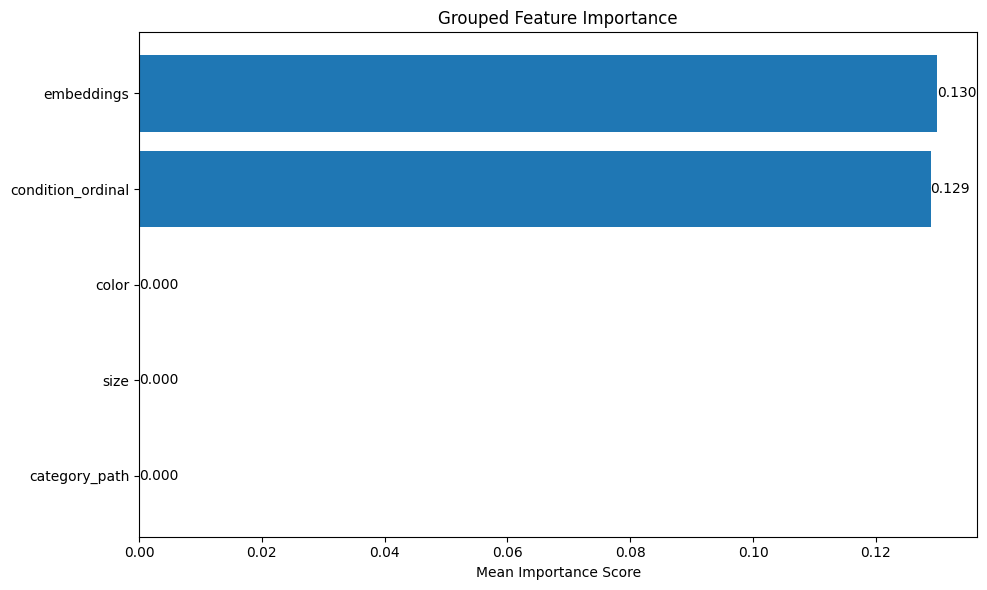

In [18]:
# TODO: Why is feature importance exactly 0 for unprocessed categorical features?
def plot_grouped_feature_importance(model, X_test_processed, original_feature_names=features, embedding_prefix='embedding_'):
    # Get feature importance scores
    feature_importance = model.get_feature_importance()
    feature_names = X_test_processed.columns
    
    # Create a dictionary to store grouped importance scores
    grouped_importance = {}
    
    # Group embedding features
    embedding_importance = np.mean([
        imp for name, imp in zip(feature_names, feature_importance)
        if name.startswith(embedding_prefix)
    ])
    grouped_importance['embeddings'] = embedding_importance
    
    # Group categorical features
    for feature in original_feature_names:
        feature_cols = [
            (name, imp) for name, imp in zip(feature_names, feature_importance)
            if name.startswith(feature)
        ]
        if feature_cols:  # If we found any columns for this feature
            grouped_importance[feature] = np.mean([imp for _, imp in feature_cols])
    
    # Create the plot
    fig, ax = plt.figure(figsize=(10, 6)), plt.axes()
    
    # Sort by importance
    sorted_importance = dict(sorted(grouped_importance.items(), key=lambda x: x[1]))
    
    # Plot horizontal bar chart
    y_pos = np.arange(len(sorted_importance))
    ax.barh(y_pos, list(sorted_importance.values()))
    ax.set_yticks(y_pos)
    ax.set_yticklabels(list(sorted_importance.keys()))
    
    plt.title('Grouped Feature Importance')
    plt.xlabel('Mean Importance Score')
    
    # Add value labels on the bars
    for i, v in enumerate(sorted_importance.values()):
        ax.text(v, i, f'{v:.3f}', va='center')
    
    plt.tight_layout()
    return plt

# Usage:
plot_grouped_feature_importance(model, X_test_processed)
plt.show()

## Model registry

In [23]:
# Creating a directory for the model artifacts if it doesn't exist
model_dir = "price_predictor_model"
if not os.path.exists(model_dir):
    os.mkdir(model_dir)

In [24]:
# Save the model locally
model.save_model(os.path.join(model_dir, "catboost_model"))

In [25]:
# TODO: Save the model to model registry